### Investigating ghost coherence

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import itertools
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak_fg, get_band_peak_fm
from fooof.bands import Bands
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from scipy.signal import find_peaks
from tqdm import tqdm

from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.util import _extract_roi, create_stages_time_grid

#### Spectral analysis parameters

In [3]:
# Smoothing windows
sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
decim = 20  # Downsampling factor
mode = "multitaper"  # Wheter to use Morlet or Multitaper

n_freqs = 80  # How many frequencies to use
freqs = np.linspace(3, 75, n_freqs)  # Frequency array
n_cycles = freqs / 4  # Number of cycles
mt_bandwidth = None


def return_evt_dt(align_at):
    """Return the window in which the data will be loaded
    depending on the alignment"""
    assert align_at in ["cue", "match"]
    if align_at == "cue":
        return [-0.7, 0.00]
    else:
        return [-2.2, 0.65]

#### Loading data

In [4]:
# Instantiate class
ses = session(
    raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
    monkey="lucy",
    date="141024",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.7, 0.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])
# ROIs with channels
rois = [
    f"{roi} ({channel})" for roi, channel in zip(data.roi.data, data.channels_labels)
]
data = data.assign_coords({"roi": rois})

In [5]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

In [6]:
band = slice(26, 43)

In [7]:
w = _tf_decomp(
    data,
    data.attrs["fsample"],
    freqs,
    mode=mode,
    n_cycles=n_cycles,
    mt_bandwidth=None,
    decim=decim,
    kw_cwt={},
    kw_mt={},
    n_jobs=20,
)

w = xr.DataArray(
    (w * np.conj(w)).real,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
    coords=(data.trials.values, data.roi.values, freqs, data.time.values[::decim]),
)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   19.6s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   25.4s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   25.7s finished


In [8]:
w = w.assign_coords({"roi": rois})

### Channels with large beta power

- F2 (36)
- F1 (63, 69, 73, 83, 84, 92, 95, 105)
- a3 (64, 65, 66, 106, 107)

In [9]:
channels = np.array([36, 63, 69, 73, 83, 84, 92, 95, 105, 64, 65, 66, 106, 107])
idx = [(ch in channels) for ch in data.channels_labels]

#### Trial-averaged spectogram

In [10]:
# Select ROIs
w_sel = w.isel(roi=idx)

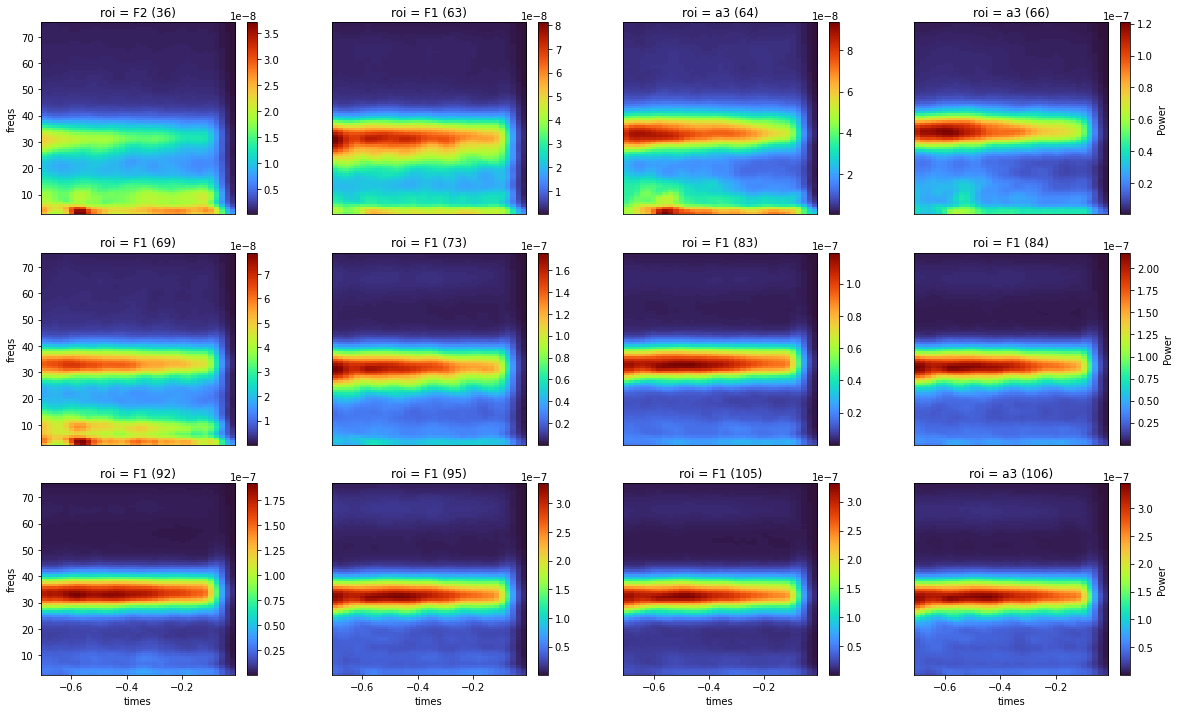

In [11]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    plt.subplot(3, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial power

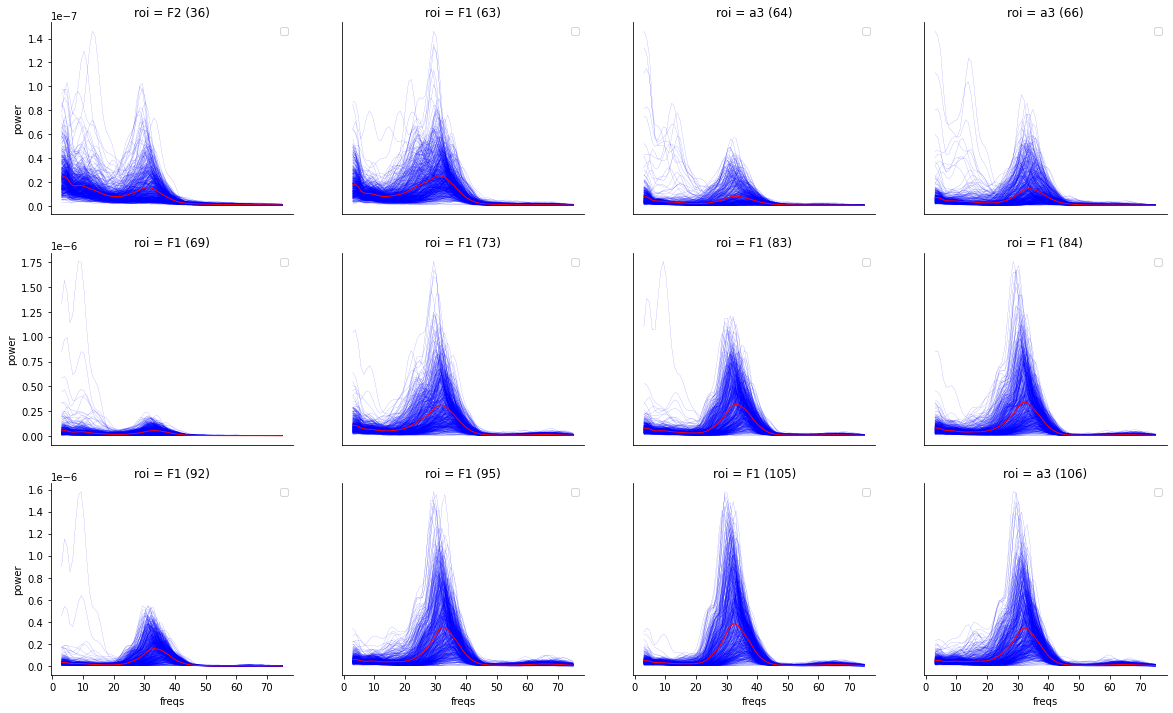

In [12]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific power time-series at single trial

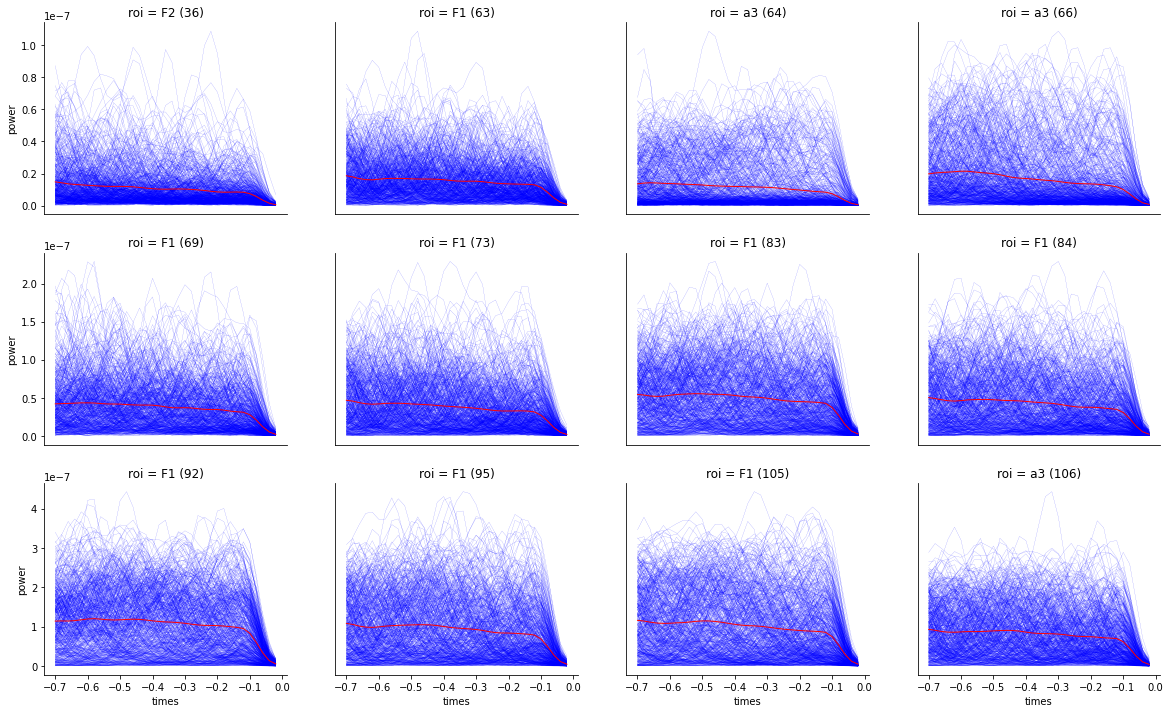

In [13]:
out = w_sel.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Ghost-coherence with V1 (236)

- 36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117

#### Trial-averaged spectogram

In [14]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
idx = [(ch in channels) for ch in data.channels_labels]

In [15]:
w_sel = w.isel(roi=idx)

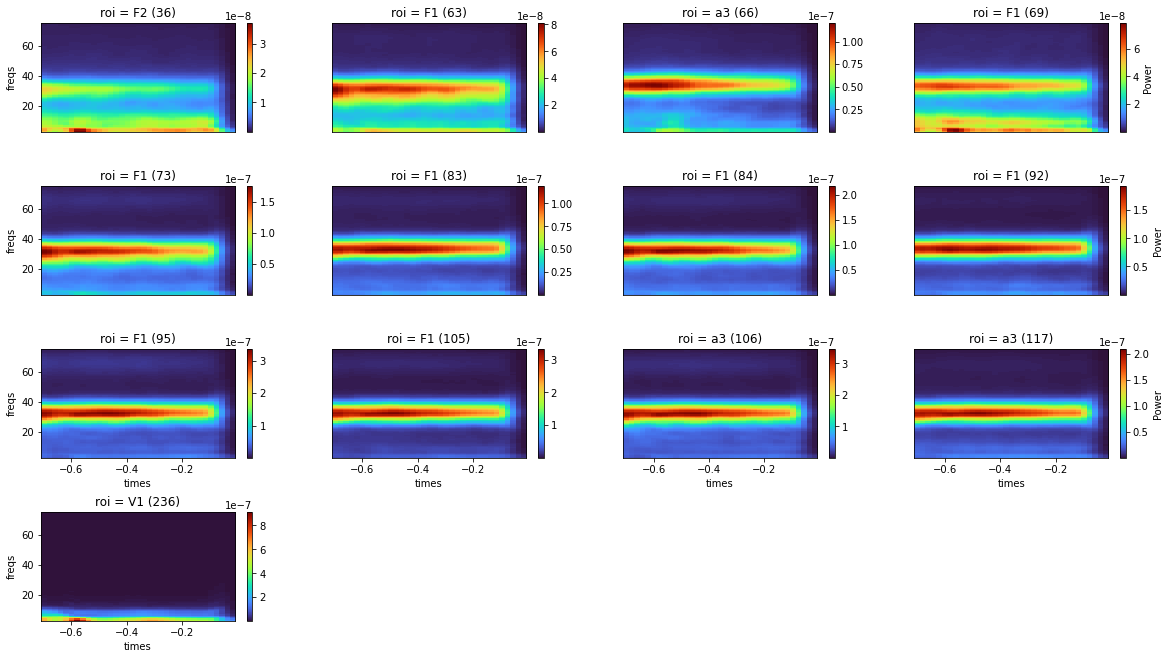

In [16]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 14))
for i in range(n_rois):
    plt.subplot(5, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
plt.subplots_adjust(hspace=0.5)

#### Time-averaged single trial power

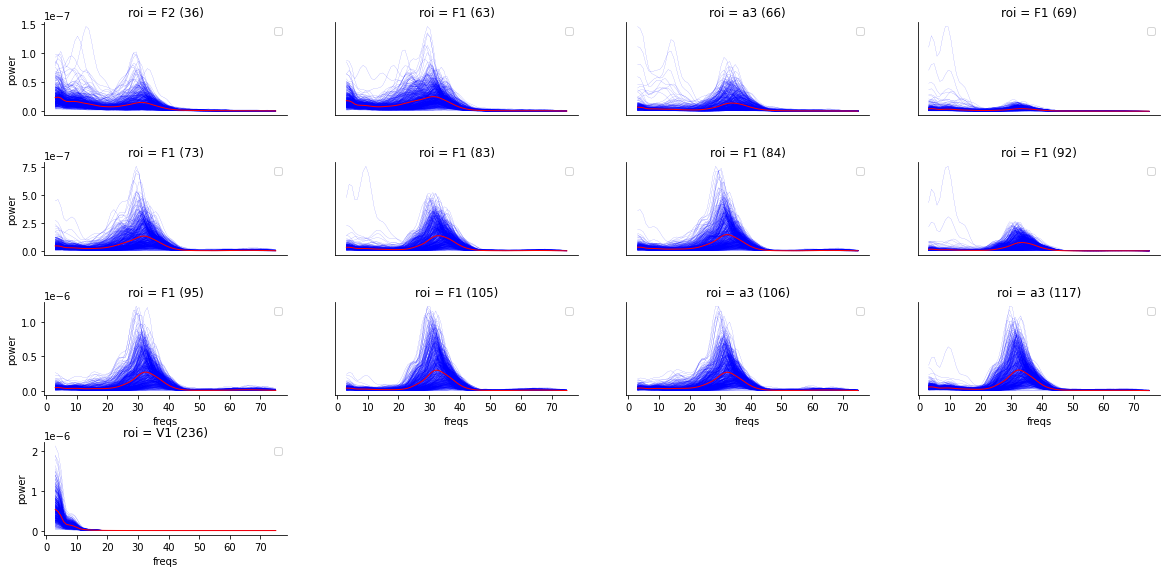

In [17]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

#### Band-specific power time-series at single trial

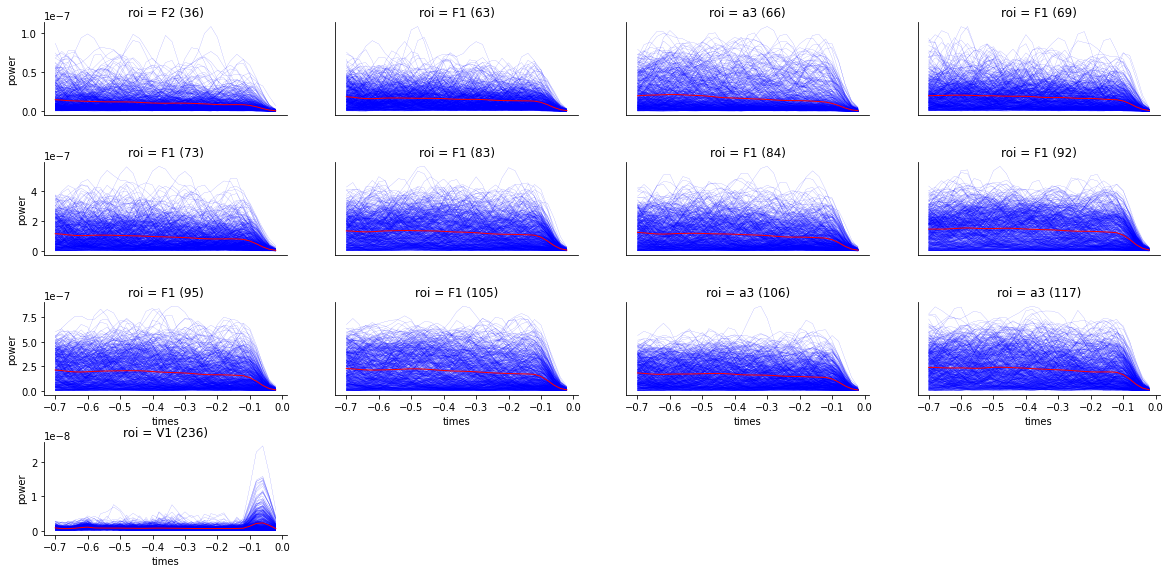

In [20]:
out = w_sel.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

### Spatial distribution of beta-power

In [21]:
bands = Bands(
    {
        "theta": [0, 6],
        "alpha": [6, 14],
        "beta": [14, 26],
        "high_beta": [26, 43],
        "gamma": [26, 43],
    }
)

In [25]:
w_static = w_sel.mean("times")

In [26]:
# Number of spectra per roi
n_spectra = w_static.sizes["trials"]
# Frequency axis
freqs = w_static.freqs.data
# Frequency range
freq_range = [freqs[0], freqs[-1]]
# ROI names
rois = w_static.roi.data
# Trial labels
trials = w_static.trials.data

peak_freqs = np.zeros((bands.n_bands, n_spectra, len(rois)))

for b in tqdm(range(bands.n_bands)):
    label = bands.labels[b]
    for i, roi in enumerate(rois):
        spectra = w_static.sel(roi=roi).data
        fg = FOOOFGroup(verbose=False)
        fg.fit(freqs, spectra, n_jobs=-1)
        peak_freqs[b, :, i] = get_band_peak_fg(fg, bands[label])[:, 1]

peak_freqs = xr.DataArray(
    peak_freqs, dims=("freqs", "trials", "roi"), coords={"trials": trials, "roi": rois}
)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.26s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.34it/s]


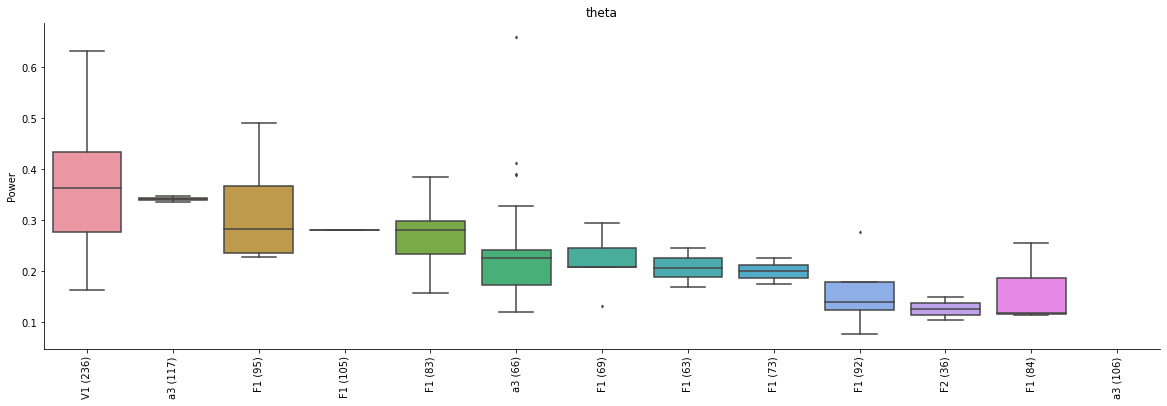

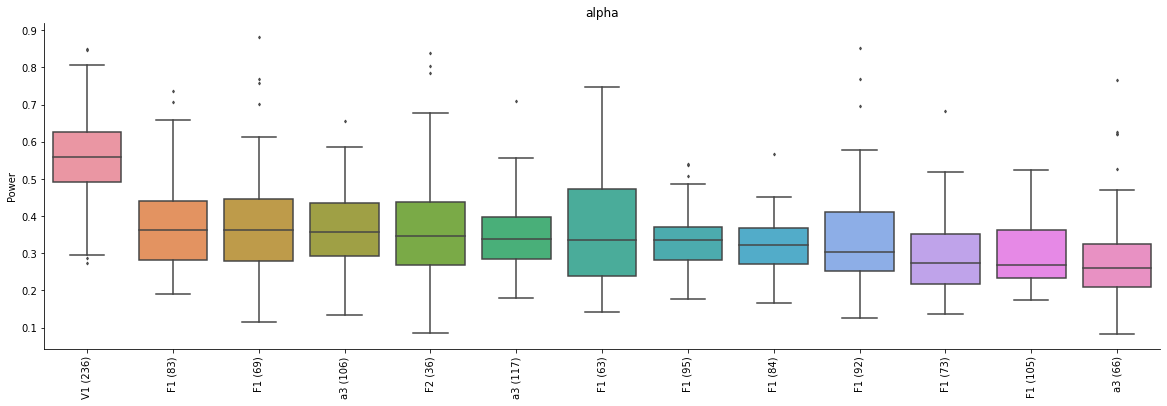

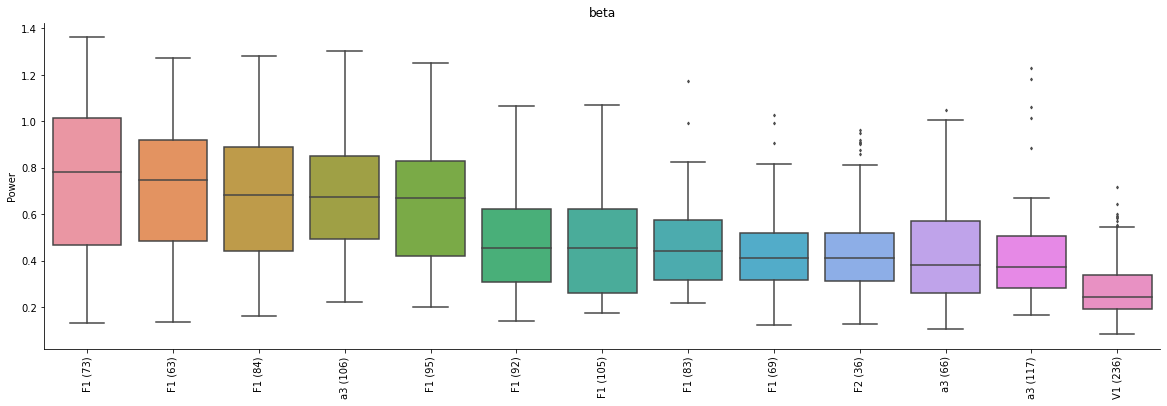

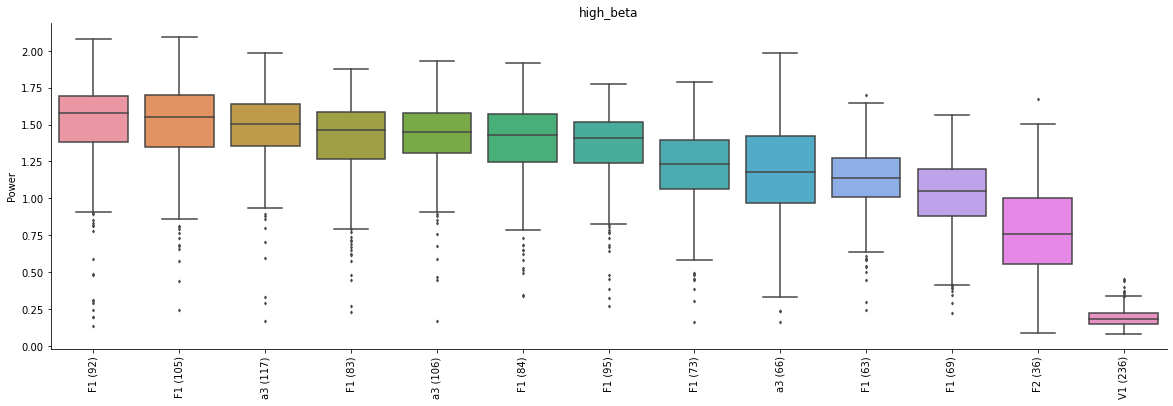

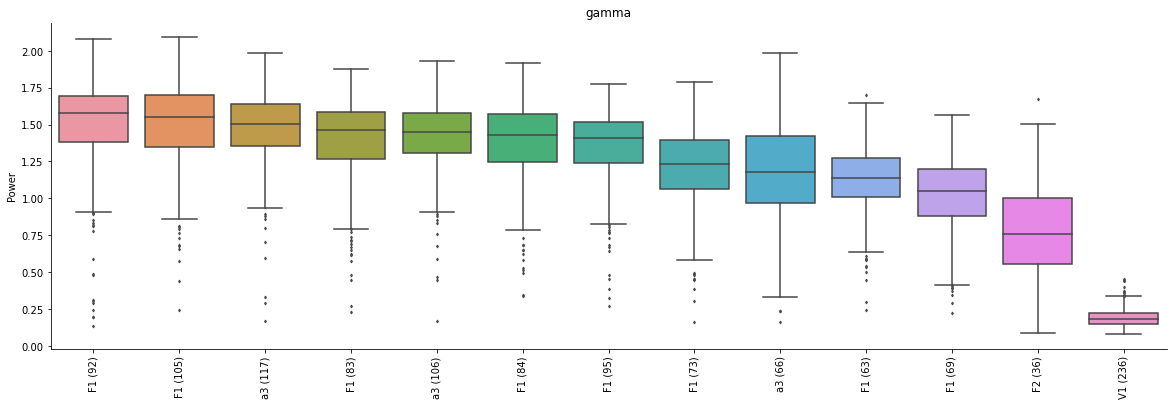

In [27]:
for b in tqdm(range(bands.n_bands)):

    df = peak_freqs.isel(freqs=b).to_dataframe("Power").reset_index()

    out = df.groupby("roi").median("Power").reset_index()

    for roi, med in zip(out.roi.values, out.Power.values):
        df.loc[(df["roi"] == roi), "median"] = med

    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    sns.boxplot(
        data=df.sort_values("median", ascending=False),
        x="roi",
        y="Power",
        flierprops=dict(markerfacecolor="0.50", markersize=2),
    )
    plt.xticks(rotation=90)
    plt.xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.title(f"{bands.labels[b]}")

### Computing coherence with V1 (236)

In [28]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117])
channel_v1 = np.array([236] * len(channels))

idx_s, idx_t = [], []

for ch in channels:
    if ch in data.channels_labels:
        idx_s.append(np.where(ch == data.channels_labels)[0][0])


for ch in channel_v1:
    if ch in data.channels_labels:
        idx_t.append(np.where(ch == data.channels_labels)[0][0])

In [29]:
pairs = np.vstack((idx_s, idx_t)).T

In [30]:
pairs = np.vstack((pairs, [27, 29]))

In [31]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    sfreq=ses.data.attrs["fsample"],
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    sm_kernel=sm_kernel,
    block_size=2,
)

# compute the coherence
coh = conn_spec(data, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=13, n_freqs=80, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   10.7s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   13.9s remaining:    0.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   13.9s finished
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/13 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   11.0s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   14.2s remaining:    0.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   14.4s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/13 [00:00<?,       ?it/s]

In [32]:
#### Surrogate data
data_surr = trial_swap_surrogates(data, seed=123456, verbose=False)

In [33]:
# compute the coherence
coh_surr = conn_spec(data_surr, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=13, n_freqs=80, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   14.0s remaining:    0.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   14.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/13 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   11.4s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   14.4s remaining:    0.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   15.0s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/13 [00:00<?,       ?it/s]

In [34]:
coh = np.clip(coh - coh_surr.quantile(0.95, "trials"), 0, np.inf)

In [35]:
coh_static = coh.mean("times")

#### Trial-averaged time-frequency coherence

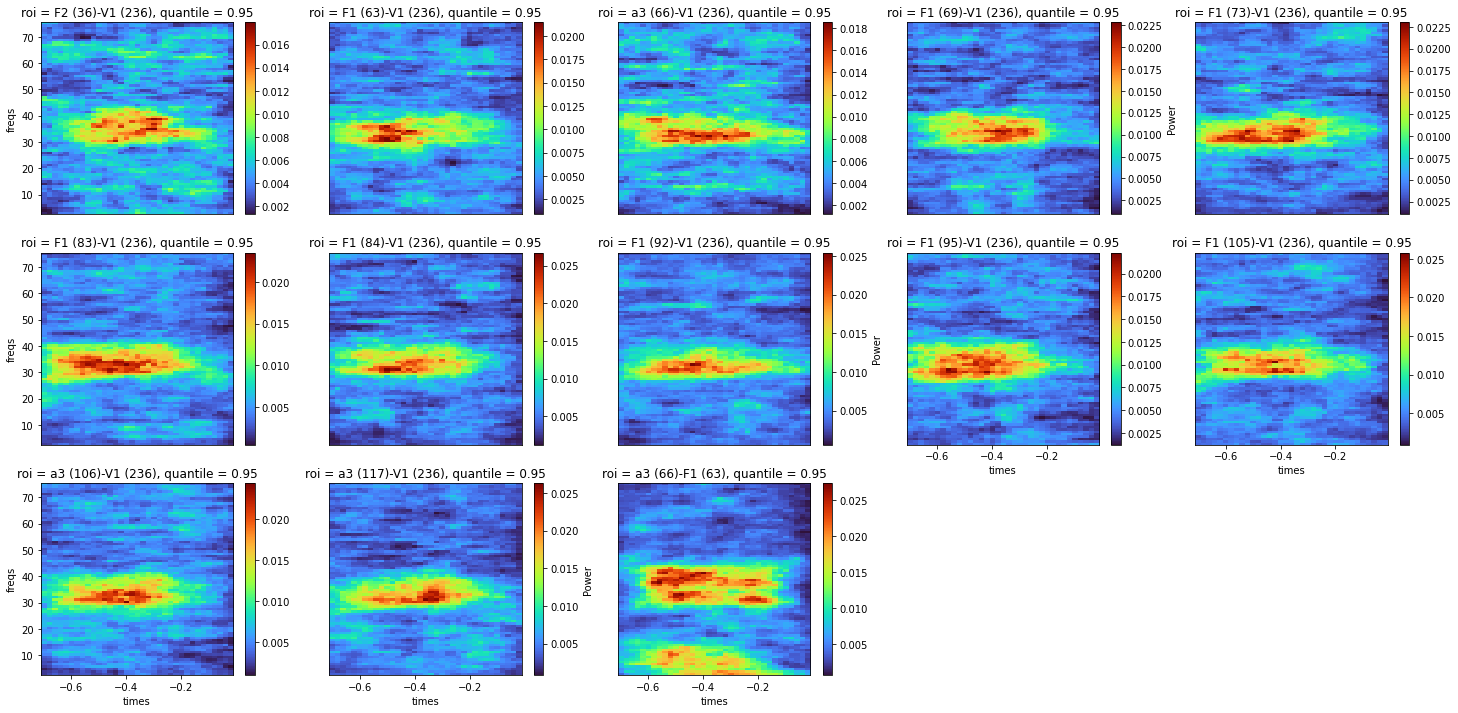

In [36]:
# Get number of ROIs
n_rois = coh.sizes["roi"]

out = coh.mean("trials")

plt.figure(figsize=(25, 12))
for i in range(n_rois):
    plt.subplot(3, 5, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 5, 10]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial coherence

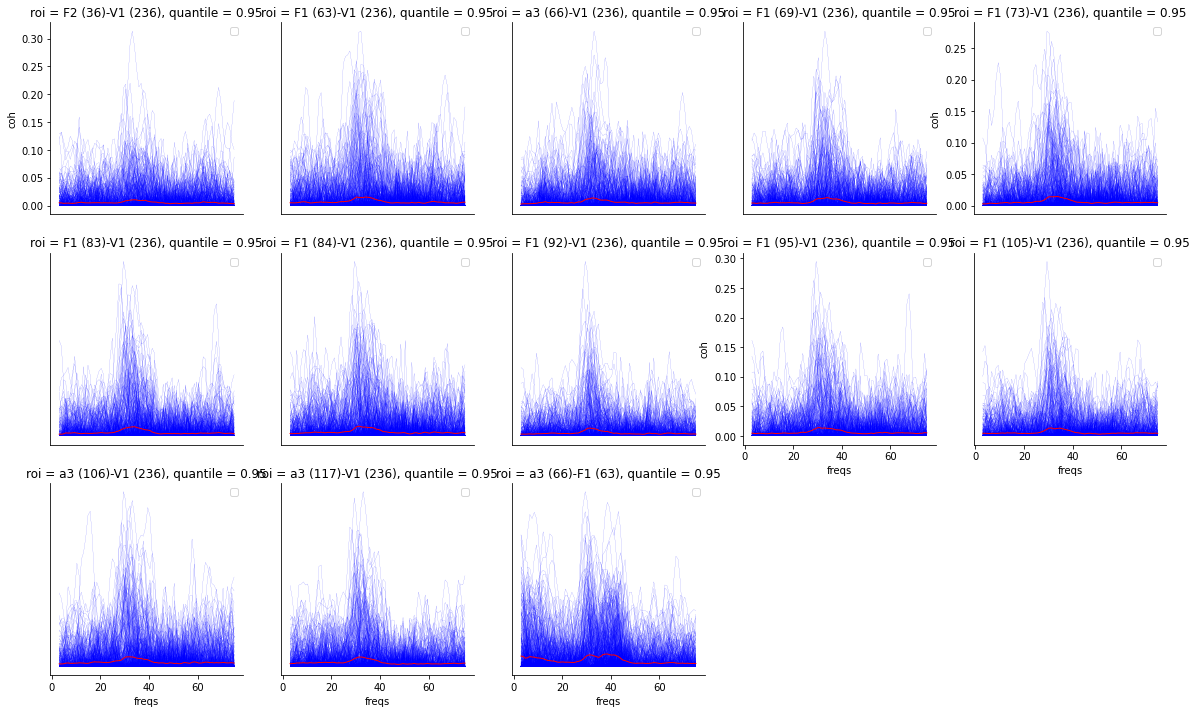

In [37]:
out = coh.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 5, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific coherence time-series at single trial

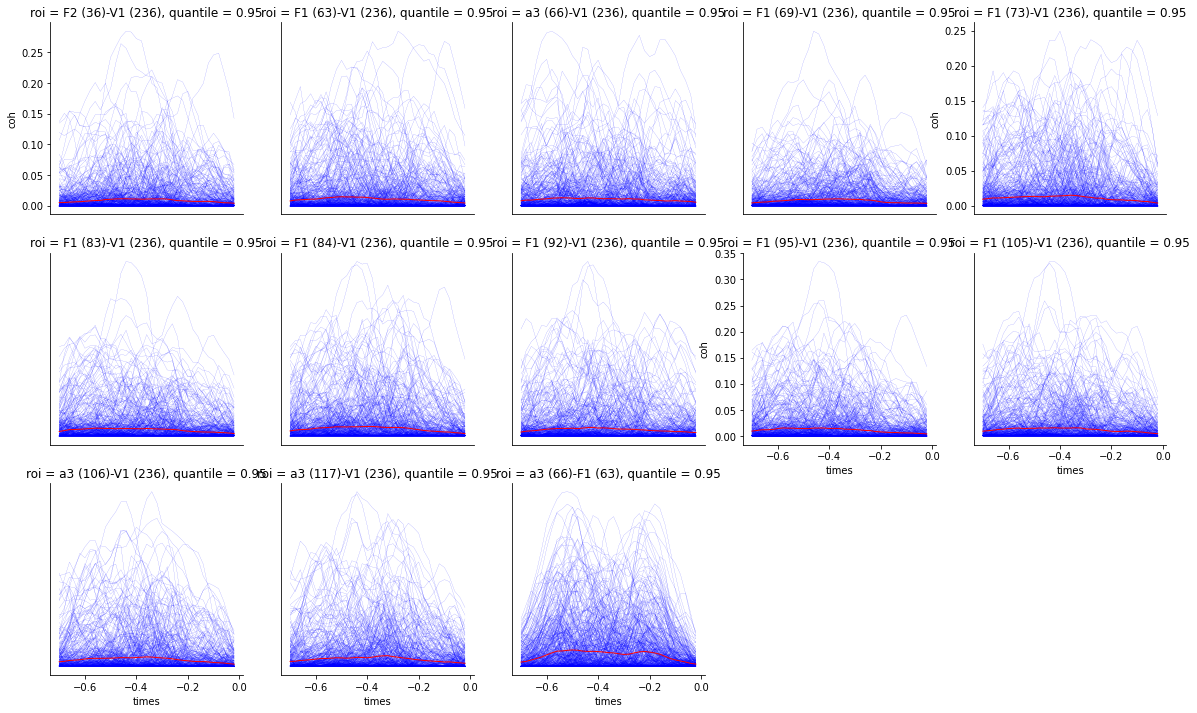

In [38]:
out = coh.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 5, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Finding peaks in the spectra and coherence

In [39]:
def detect_peaks(
    data, norm=None, kw_peaks={}, return_value=None, verbose=False, n_jobs=1
):

    assert isinstance(data, xr.DataArray)
    np.testing.assert_array_equal(data.dims, ["trials", "roi", "freqs"])

    # Names of properties in kw_peaks
    p_names = ["".join(list(key)) for key in kw_peaks.keys()]

    if norm:
        assert norm in ["max", "area"]
        if norm == "max":
            norm_values = data.max("freqs")
        else:
            norm_values = data.integrate("freqs")
        data = data / norm_values

    n_trials, n_rois = data.sizes["trials"], data.sizes["roi"]

    # Compute for each roi
    def _for_roi(i):
        peaks = np.zeros((n_trials, n_freqs))
        for t in range(n_trials):
            out, properties = find_peaks(data[t, i, :].data, **kw_peaks)
            if return_value is None:
                peaks[t, out] = 1
            else:
                peaks[t, out] = properties[return_value]
        return peaks

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_roi, n_jobs=n_jobs, verbose=verbose, total=n_rois
    )
    # Compute the single trial coherence
    peaks = parallel(p_fun(i) for i in range(n_rois))

    peaks = xr.DataArray(
        np.stack(peaks, 1), dims=data.dims, coords=data.coords, name="prominence"
    )

    return peaks

#### Peak prominence distribution for coherence

In [62]:
p_coh = detect_peaks(
    coh_static,
    kw_peaks=dict(height=0.0, prominence=0),
    return_value="prominences",
    norm=None,
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

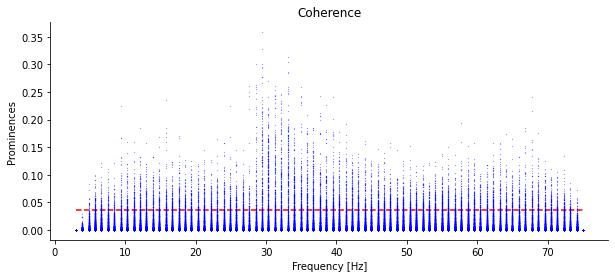

In [63]:
max_pro_coh = p_coh.max().data
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for f in range(p_coh.sizes["freqs"]):
    # Get prominences for all trials and roi for this given frequency
    pro = p_coh.isel(freqs=f).data.flatten()
    x = np.ones_like(pro) * p_coh.freqs.data[f]
    plt.plot(x, pro, ".b", ms=0.3)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1 * max_pro_coh, freqs[0], freqs[-1], "r", ls="--")
plt.ylabel("Prominences")
plt.xlabel("Frequency [Hz]")
plt.title("Coherence");

In [46]:
p_coh = detect_peaks(
    coh_static,
    kw_peaks=dict(height=0.1, prominence=0.1 * max_pro_coh),
    return_value=None,
    norm=None,
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

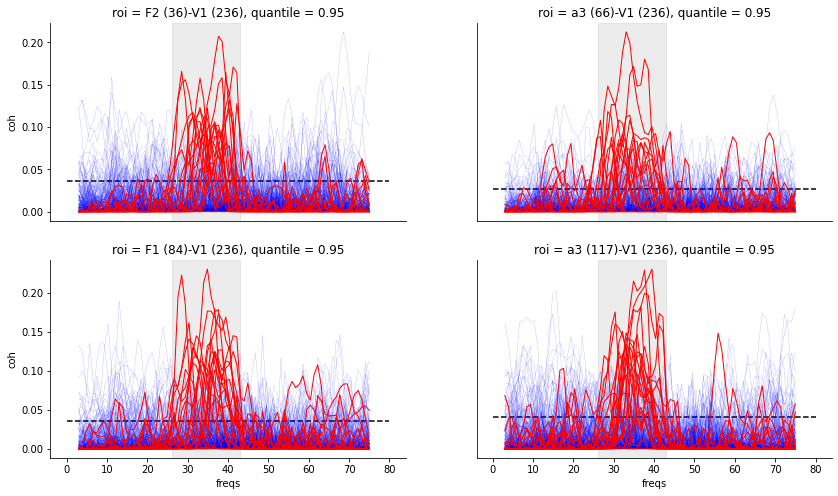

In [47]:
plt.figure(figsize=(14, 8))
for i, r in enumerate([0, 2, 6, 11]):
    ax = plt.subplot(2, 2, i + 1)

    # Index of trial that have a peak
    idx = p_coh.isel(roi=r).sel(freqs=band).sum("freqs") > 0

    coh_static.isel(roi=r, trials=np.logical_not(idx)).plot(
        x="freqs", hue="trials", lw=0.1, color="blue"
    )

    if np.sum(idx) > 0:
        coh_static.isel(roi=r).isel(trials=idx).isel(trials=slice(0, 20)).plot(
            x="freqs", hue="trials", color="red", lw=1
        )

    ax.get_legend().remove()
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if i < 2:
        plt.xticks([])
        plt.xlabel("")
    if i % 2:
        plt.yticks([])
        plt.ylabel("")
    plt.hlines(0.1 * max_pro_coh, 0, coh_static.sizes["freqs"], color="black", ls="--")

|           | Power i | Power j | Coh ij |     Outcome    |
|:---------:|:-------:|:-------:|:------:|:--------------:|
| Has peak? |    T    |    T    |    T   |  True positive |
|           |    T    |    T    |    F   | False negative |
|           |    T    |    F    |    F   |  True negative |
|           |    F    |    T    |    T   | False positive |
|           |    F    |    F    |    T   | False positive |
|           |    F    |    F    |    F   |  True negative |

#### Checking for channel F2 and V1

In [48]:
p_band = (peak_freqs > 0).astype(int)

In [49]:
bands = np.array([[0, 6], [6, 14], [14, 26], [26, 43], [43, 80]])

p_coh_band = []
for i, (flow, fhigh) in enumerate(bands):
    p_coh_band += [(p_coh.sel(freqs=slice(flow, fhigh)).sum("freqs") > 0).astype(int)]

p_coh_band = xr.concat(p_coh_band, "freqs")

In [50]:
O1 = p_coh_band.isel(roi=6) * (
    p_band.isel(roi=6) + p_band.isel(roi=-1)
) + p_coh_band.isel(roi=6)

O2 = p_coh_band.isel(roi=-1) * (
    p_band.isel(roi=1) + p_band.isel(roi=2)
) + p_coh_band.isel(roi=-1)

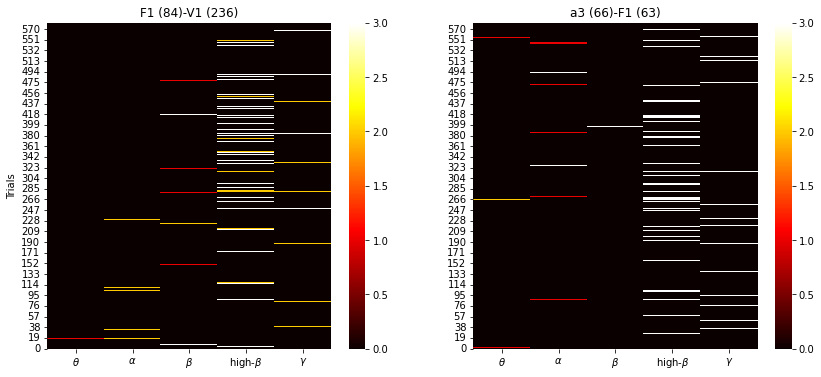

In [51]:
plt.figure(figsize=(14, 6))

ax = plt.subplot(1, 2, 1)
sns.heatmap(data=O1.T, cmap="hot", cbar=True, vmax=3)
ax.invert_yaxis()
plt.title(f"{O1.roi.data}")
plt.yticks(rotation=0)
plt.ylabel("Trials")
plt.xticks(
    np.arange(0.5, 5.5),
    [r"$\theta$", r"$\alpha$", r"$\beta$", r"high-$\beta$", r"$\gamma$"],
)

ax = plt.subplot(1, 2, 2)
sns.heatmap(data=O2.T, cmap="hot", cbar=True, vmax=3)
ax.invert_yaxis()
plt.title(f"{O2.roi.data}")
plt.yticks(rotation=0)
plt.ylabel("Trials")
plt.ylabel("")
plt.xticks(
    np.arange(0.5, 5.5),
    [r"$\theta$", r"$\alpha$", r"$\beta$", r"high-$\beta$", r"$\gamma$"],
);

In [52]:
(O1.isel(freqs=3) == 2).sum() / (
    (O1.isel(freqs=3) == 2).sum() + (O1.isel(freqs=3) == 3).sum()
)

<xarray.DataArray ()>
array(0.28813559)
Coordinates:
    roi       <U17 'F1 (84)-V1 (236)'
    quantile  float64 0.95

In [53]:
idx = O1.isel(freqs=3) == 2
idx2 = O1.isel(freqs=3) == 3

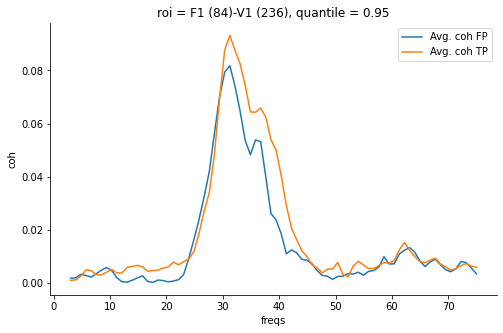

In [54]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
coh_static.isel(roi=6, trials=idx).mean("trials").plot(x="freqs")
coh_static.isel(roi=6, trials=idx2).mean("trials").plot(x="freqs")
plt.legend(["Avg. coh FP", "Avg. coh TP"])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [55]:
fpi = np.where(O1.isel(freqs=3) == 2)
tpi = np.where(O1.isel(freqs=3) == 3)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

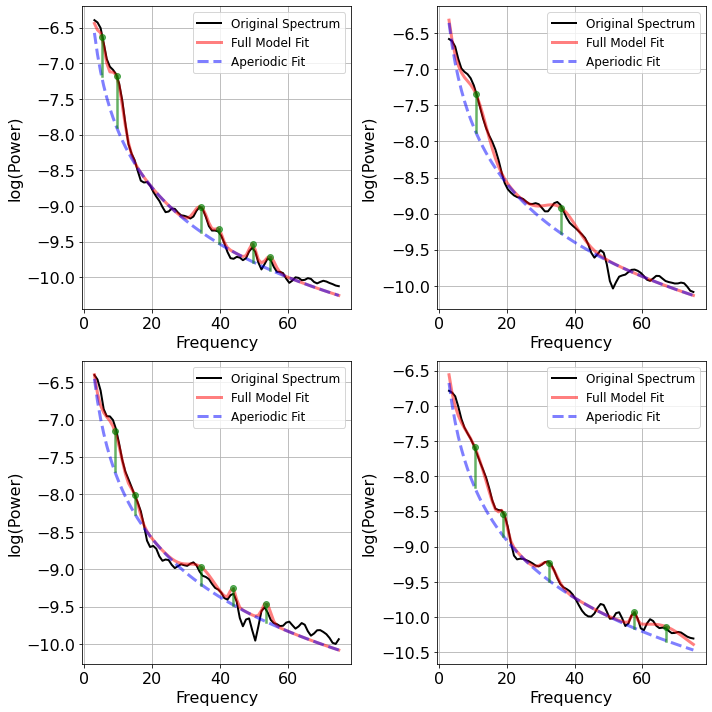

In [61]:
c = 0
plt.figure(figsize=(10, 10))
for i in np.random.choice(tpi[0], 4):

    ax = plt.subplot(2, 2, c + 1)

    freqs = w_static.freqs.values

    # Initialize a FOOOF object
    fm = FOOOF()

    # Set the frequency range to fit the model
    freq_range = [freqs[0], freqs[-1]]

    spectrum = w_static.sel(roi="V1 (236)").isel(trials=i).values

    # Report: fit the model, print the resulting parameters, and plot the reconstruction
    # fm.report(freqs, spectrum, freq_range)
    fm.add_data(freqs, spectrum)
    fm.fit()
    fm.plot(plot_peaks="dot", ax=ax)

    c = c + 1

No handles with labels found to put in legend.


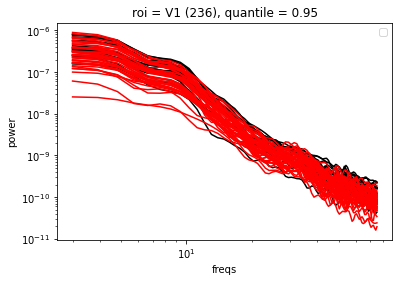

In [57]:
w_static.sel(roi="V1 (236)").isel(trials=idx).plot.line(
    x="freqs", hue="trials", color="k", xscale="log", yscale="log"
)
w_static.sel(roi="V1 (236)").isel(trials=idx2).plot.line(
    x="freqs", hue="trials", color="r", xscale="log", yscale="log"
)

plt.legend()

In [58]:
w_static.sel(roi="V1 (236)", freqs=slice(23, 40)).isel(trials=idx2).max()

<xarray.DataArray 'power' ()>
array(2.69147874e-09)
Coordinates:
    roi       <U9 'V1 (236)'
    quantile  float64 0.95

No handles with labels found to put in legend.


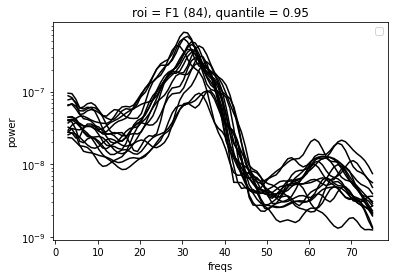

In [59]:
w_static.sel(roi="F1 (84)").isel(trials=idx).plot.line(
    x="freqs", hue="trials", color="k", yscale="log"
)
plt.legend()

### Ghost-coherence from time-series

In [44]:
# Power beta time-series
w_beta = w_sel.sel(freqs=slice(26, 43)).mean("freqs")
# Coherence beta time-series
coh_beta = coh.sel(freqs=slice(26, 43)).mean("freqs")

In [45]:
# Compute thresholds for each roi
q = []
for roi in tqdm(w_beta.roi.data):
    q += [np.quantile(w_beta.sel(roi=roi).data.flatten(), 0.95)]
q = xr.DataArray(q, dims=("roi"), coords={"roi": w_beta.roi.data})

100%|███████████████████████████████████████████████████████| 13/13 [00:00<00:00, 853.29it/s]


Text(0.5, 1.0, 'Power thresholds')

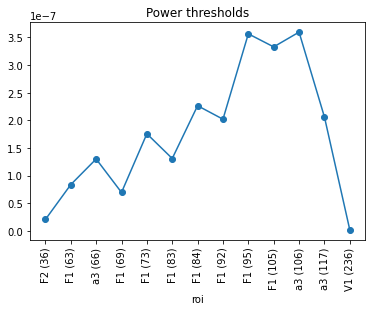

In [46]:
q.plot(x="roi", marker="o")
plt.xticks(rotation=90)
plt.title("Power thresholds")

In [47]:
w_beta_b = w_beta >= q

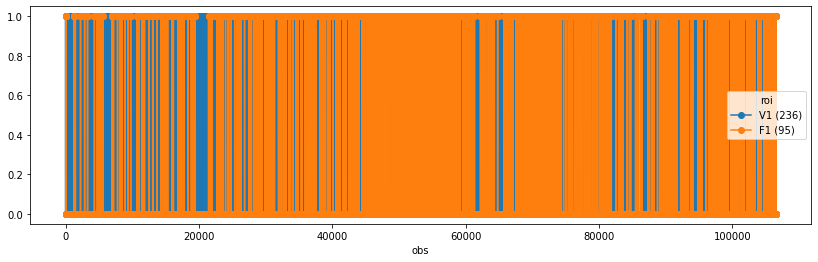

In [48]:
plt.figure(figsize=(14, 4))
w_beta_b.stack(obs=("trials", "times")).sel(roi=["V1 (236)", "F1 (95)"]).reset_index(
    "obs"
).plot(x="obs", hue="roi", marker="o")

In [49]:
from scipy.spatial.distance import hamming

In [50]:
u = w_beta_b.isel(trials=0).sel(roi="V1 (236)")
v = w_beta_b.isel(trials=0).sel(roi="F1 (95)")
hamming(u, v) / len(u)

0.0009256770879990444

In [51]:
out = (
    np.logical_and(w_beta_b.sel(roi="V1 (236)"), w_beta_b.sel(roi="F1 (95)")).sum(
        "times"
    )
    / w_beta_b.sizes["times"]
)

In [88]:
t_tp = O1.trials.data[O1.isel(freqs=3) == 3]

In [89]:
w_beta_mean = w_beta.sel(trials=t_tp).mean("trials")
w_beta_mean = (w_beta_mean - w_beta_mean.mean("times")) / w_beta_mean.std("times")

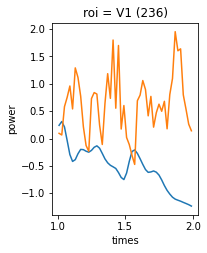

In [90]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 4, i)
w_beta_mean.sel(roi="F1 (84)", times=slice(1, 2)).plot()
w_beta_mean.sel(roi="V1 (236)", times=slice(1, 2)).plot()
i = i + 1